## Custom Decision Tree + Naive Bayes Classifier Notebook

In [1]:
import os
import uuid
import time
import random
import cv2
import numpy as np
from enum import Enum
from tqdm import tqdm
import matplotlib.pyplot as plt

class Colour(Enum):
    black = 1
    blue = 2
    brown = 3
    green = 4
    red = 5
    white = 6
    yellow = 7

dir_name = r'C:\Users\mikho\Desktop\KI\CustomDecisionTree + NaiveBayesClassifier\Data'

***Folder structure:***
- ***Data***
    - *black*
    - *blue*
    - *brown*
    - *green*
    - *red*
    - *white*
    - *yellow*
    - ***cut_bars***
        - *black*
        - *blue*
        - *brown*
        - *green*
        - *red*
        - *white*
        - *yellow*

In [2]:
def resize_img(img, width = 1000, square = False ):
    if square:
        height = width
    else:
        height = int(img.shape[0] * width / img.shape[1])
    dim = (width, height)
    resized_img  = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    return resized_img 

In [3]:
def crop_img(img, box, rect, zoom=1.3, angle=0):
    # Extract the width and height of the rectangle
    width = int(rect[1][0])
    height = int(rect[1][1])
    
    # Define the source and destination points for perspective transformation
    src_pts = box.astype("float32")
    dst_pts = np.array([[0, height-1],
                        [0, 0],
                        [width-1, 0],
                        [width-1, height-1]], dtype="float32")

    # Compute the perspective transformation matrix
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    
    # Warp the image using the perspective transformation matrix
    warped_img = cv2.warpPerspective(img, M, (width, height))
    
    # Calculate the center coordinates of the warped image
    cy, cx = [i/2 for i in warped_img.shape[:-1]]
    
    # Create the rotation matrix for affine transformation
    rot_mat = cv2.getRotationMatrix2D((cx, cy), angle, zoom)
    
    # Apply the affine transformation to the warped image
    result = cv2.warpAffine(warped_img, rot_mat, warped_img.shape[1::-1], flags=cv2.INTER_LINEAR)
    
    # Return the resulting cropped and rotated image
    return result

### The **get_bounding_rect_colours()** method is designed to extract a bounding rectangle around specific colors in an image. 
- doesnt work on white bars(-)



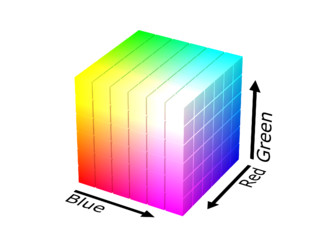

In [45]:
# Color boundaries for various colors in BGR format
# 'l' represents lower boundary, 'u' represents upper boundary
boundaries = {
    'red': {'l': np.array([0, 0, 100], dtype="uint8"), 'u': np.array([150, 150, 255], dtype="uint8")},
    'green': {'l': np.array([0, 50, 0], dtype="uint8"), 'u': np.array([100, 255, 100], dtype="uint8")},
    'brown': {'l': np.array([0, 30, 20], dtype="uint8"), 'u': np.array([100, 220, 255], dtype="uint8")},
    'black': {'l': np.array([0, 0, 0], dtype="uint8"), 'u': np.array([100, 100, 100], dtype="uint8")},
    'blue': {'l': np.array([20, 0, 0], dtype="uint8"), 'u': np.array([255, 100, 60], dtype="uint8")},
    'yellow': {'l': np.array([0, 100, 100], dtype="uint8"), 'u': np.array([100, 255, 255], dtype="uint8")},
    'white': {'l': np.array([150, 150, 150], dtype="uint8"), 'u': np.array([255, 255, 255], dtype="uint8")}
}

def get_bounding_rect_colours(img, colour):
    # Create a binary mask based on the color boundaries
    mask = cv2.inRange(img, boundaries[colour]['l'], boundaries[colour]['u'])
    
    # Apply the mask to the original image
    output = cv2.bitwise_and(img, img, mask=mask)
    
    # Threshold the mask to obtain a binary image
    ret, thresh = cv2.threshold(mask, 40, 255, 0)
    
    # Find contours in the binary image
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    
    # Find the contour with the maximum area
    cnt = max(contours, key=cv2.contourArea)
    
    # Find the minimum area rectangle that encloses the contour
    rect = cv2.minAreaRect(cnt)
    
    # Get the four corner points of the minimum area rectangle
    box = cv2.boxPoints(rect)
    box = np.intp(box)
    
    return box, rect

### The get_bounding_rect_filters() method is designed to extract bounding rectangles from an image using various image filtering and analysis techniques. 
 + works on some white bars(+)
 + doesnt work if camera flash(-) 
 + doesnt work well on yellow bars(-)

In [63]:
def get_bounding_rect_filters(img, multiple=False, max_num_cnts=20, cmp_area = 0.5):
    # Convert the image to grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Apply adaptive thresholding to create a binary image
#    thresh = cv2.adaptiveThreshold(img_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 75, 5)
    thresh = cv2.adaptiveThreshold(img_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 125, 5)
    
    # Apply bilateral filtering to reduce noise
    median_blur = cv2.bilateralFilter(thresh, 15, 15, 55)
    
    # Perform connected component analysis
    nlabels, labels, stats, centroids = cv2.connectedComponentsWithStats(median_blur, None, None, None, 8, cv2.CV_32S)
    areas = stats[1:, cv2.CC_STAT_AREA]
    
    # Create an empty image for the result
    result = np.zeros(labels.shape, np.uint8)
    
    # Iterate over the connected components
    for i1 in range(0, nlabels - 1):
        if areas[i1] >= 100:  # Keep the connected component if its area is greater than or equal to 100
            result[labels == i1 + 1] = 255
    
    # Find contours in the result image
    contours, hierarchy = cv2.findContours(result, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    # Sort the contours based on contour area in descending order
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    
    # Create a list to store the rectangles and their corresponding contour indices
    rectangles = []
    
    # Iterate over each contour
    for contour in contours[:max_num_cnts * 3]:
        # Find the minimum area rectangle around the contour
        rect = cv2.minAreaRect(contour)
        
        # Calculate the area of the minimum area rectangle
        area = rect[1][0] * rect[1][1]
        
        # Append the rectangle and its contour index to the list
        rectangles.append((area, rect))
    
    # Sort the rectangles based on area in descending order
    rectangles = sorted(rectangles, key=lambda x: x[0], reverse=True)
    
    if multiple:
        # Keep only the rectangles with an area ratio greater than 0.5 compared to the largest rectangle
        max_area = rectangles[0][0]
        boxes = []
        rects = []
        
        for rect in rectangles[:max_num_cnts]:
            if rect[0] / max_area < cmp_area:
                break
            box = cv2.boxPoints(rect[1])
            boxes.append(np.intp(box))
            rects.append(rect[1])
        
        return boxes, rects
    else:
        # Get the largest rectangle
        box = cv2.boxPoints(rectangles[0][1])
        box = np.intp(box)
        return box, rectangles[0][1]


### Check if get_bounding_rect_filters() can find countours around more then 1 chocolate  bar

(-0.5, 4623.5, 2603.5, -0.5)

<Figure size 1000x1000 with 0 Axes>

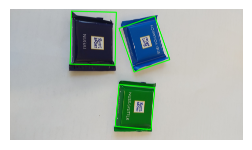

In [65]:
plt.figure(figsize=(10, 10))
f, axarr = plt.subplots(1, 1) 

img = cv2.imread(r'C:\Users\mikho\Desktop\KI\VdKI_Projekt SS2023\Bilder_Rittersport_SS2023\20230414_130356\20230414_130506.jpg')
#img = cv2.imread(r'C:\Users\mikho\Desktop\KI\CustomDecisionTree + NaiveBayesClassifier\Bilder\IMG_1827.jpg')
#img = resize_img(img)
colour_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

boxes, _ = get_bounding_rect_filters(img, multiple=True, cmp_area = 0.3) 
for box in boxes:
    colour_img = cv2.drawContours(colour_img,[box],0,(0,255,0),20)
axarr.imshow(colour_img)
axarr.axis('off')

### Test crop_img()

(-0.5, 999.5, 1774.5, -0.5)

<Figure size 300x1000 with 0 Axes>

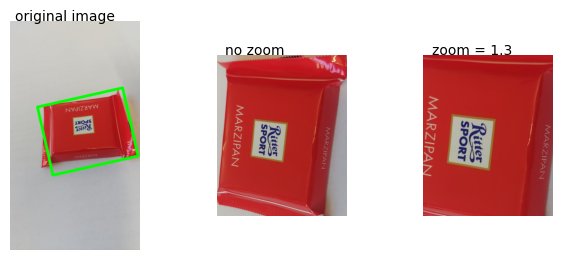

In [48]:
plt.rcParams['figure.figsize'] = [3, 10]
plt.figure()

f, axarr = plt.subplots(nrows=1, ncols=3, figsize=(7, 7),
                       gridspec_kw={
                           'width_ratios': [1, 1, 1],
                           'height_ratios': [1],
                       'wspace': 0.6,
                       'hspace': 0.4})
 

img = cv2.imread(r'C:\Users\mikho\Desktop\KI\VdKI_Projekt SS2023\Bilder_Rittersport_SS2023\20230414_130356\20230414_130145.jpg')
img = resize_img(img)

colour_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
box, rect = get_bounding_rect_filters(img)
axarr[1].imshow(crop_img(colour_img, box, rect, zoom=1))
axarr[1].text(35, 0, f"no zoom", size=10)
axarr[1].axis('off')

axarr[2].imshow(crop_img(colour_img, box, rect))
axarr[2].text(35, 0, f"zoom = 1.3", size=10)
axarr[2].axis('off')

colour_img = cv2.drawContours(colour_img,[box],0,(0,255,0),20)
axarr[0].imshow(colour_img)
axarr[0].text(35, 0, f"original image", size=10)
axarr[0].axis('off')

### Test and compare get_bounding_rect_filters() and get_bounding_rect_colours() extraction methods

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:06<00:00,  1.08it/s]


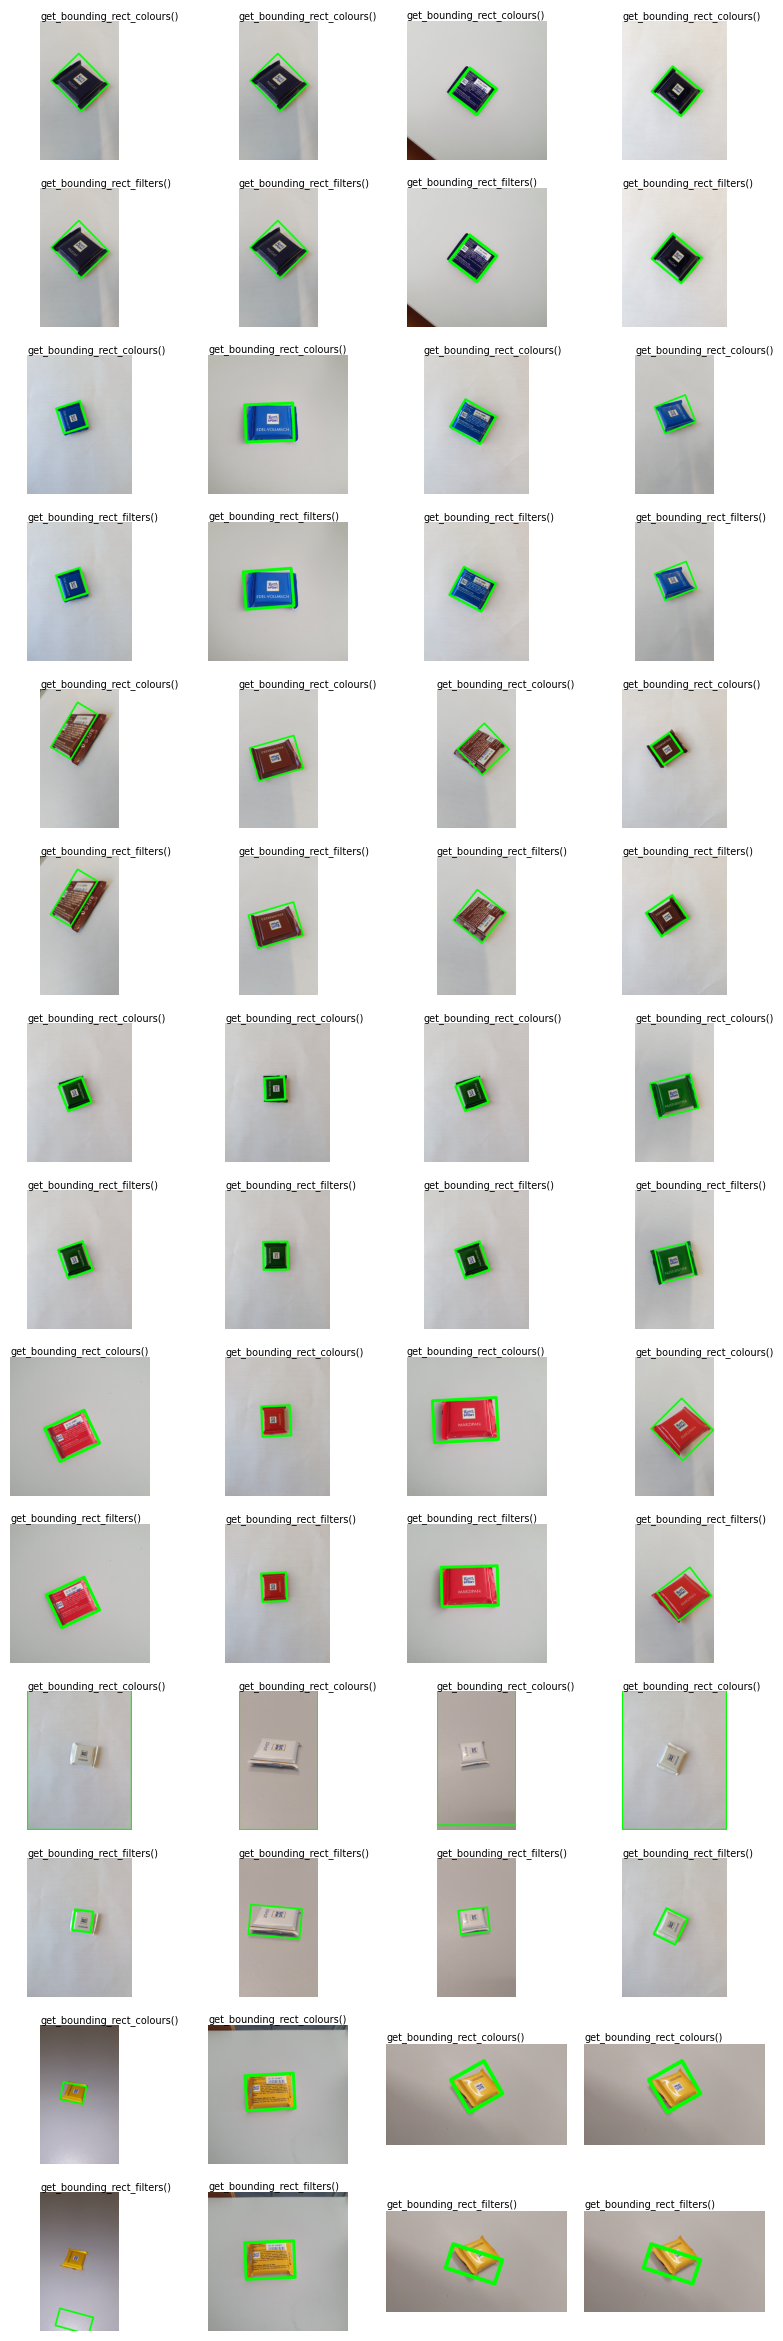

In [38]:
# plt.figure()

rows_num = 14
cols_num = 4

fig, axarr = plt.subplots(
    nrows=rows_num,
    ncols=cols_num,
    figsize=(10, 30),
    gridspec_kw={
        'width_ratios': [5 for _ in range(cols_num)],
        'height_ratios': [1 for _ in range(rows_num)],
        'wspace': 0.1,
        'hspace': 0.2,
    }
)



# Iterate over each color
for colour in tqdm(Colour):
    # Generate a list of random file names from the corresponding color directory
    file_names = [random.choice(os.listdir('%s\%s' % (dir_name, colour.name))) for i in range(cols_num)] 

    # Iterate over the selected files
    for i in range(cols_num):
        # Build the image path
        img_name = r'%s\%s\%s' % (dir_name, colour.name, file_names[i])
        img = cv2.imread(img_name)
        img = resize_img(img)

        # Create a copy of the image for the first method (by colours)
        colour_img1 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Create a copy of the image for the second method (by filters)
        colour_img2 = colour_img1.copy()

        # Get the bounding rectangle using the custom method for the current color
        box1, rect1 = get_bounding_rect_colours(img, colour.name)

        # Draw the bounding rectangle on the image for the first method
        colour_img1 = cv2.drawContours(colour_img1, [box1], 0, (0, 255, 0), 20)

        # Display the image with the first method's result
        axarr[(colour.value - 1) * 2][i].imshow(colour_img1)
        axarr[(colour.value - 1) * 2][i].text(0, -25, f"get_bounding_rect_colours()", size=7)
        axarr[(colour.value - 1) * 2][i].axis('off')


        # Get the bounding rectangle using the filters method
        box2, rect2 = get_bounding_rect_filters(img)

        # Draw the bounding rectangle on the image for the second method
        colour_img2 = cv2.drawContours(colour_img2, [box2], 0, (0, 255, 0), 20)

        # Display the image with the second method's result
        axarr[(colour.value - 1) * 2 + 1][i].imshow(colour_img2)
        axarr[(colour.value - 1) * 2 + 1][i].text(0, -25, f"get_bounding_rect_filters()", size=7)
        axarr[(colour.value - 1) * 2 + 1][i].axis('off')
        axarr[(colour.value - 1) * 2 + 1][i].spines['right'].set_visible(True)

# Extract bars
and put them in separate folders inside 'cut_bars' folder

In [41]:
%%time

color_file = {col.name:os.listdir('%s\%s'%(dir_name, col.name)) for col in (Colour)}

for colour, files_list in tqdm(color_file.items()):
    if colour == 'white':
        continue
    for file_name in files_list:
        img_name = r'%s\%s\%s'%(dir_name, colour, file_name)
        img = cv2.imread(img_name)
        img = resize_img(img)
        box, rect = get_bounding_rect_colours(img, colour)
        
        croped_img = crop_img(img, box, rect)
        feature_img_name = r'%s\cut_bars\%s\%s'%(dir_name, colour, file_name)
        croped_img = resize_img(croped_img, 256, True)
        cv2.imwrite(feature_img_name, croped_img)

folder = 'white' 
for file_name in color_file[folder]:
    img_name = r'%s\%s\%s'%(dir_name, folder, file_name)
    img = cv2.imread(img_name)
    img = resize_img(img)
    box, rect = get_bounding_rect_filters(img)
    croped_img = crop_img(img, box, rect)
    feature_img_name = r'%s\cut_bars\%s\%s'%(dir_name, folder, file_name)
    croped_img = resize_img(croped_img, 256, True)
    cv2.imwrite(feature_img_name, croped_img)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:35<00:00,  5.07s/it]


CPU times: total: 1min 11s
Wall time: 47 s


# Check extracted images
and remove bad ones

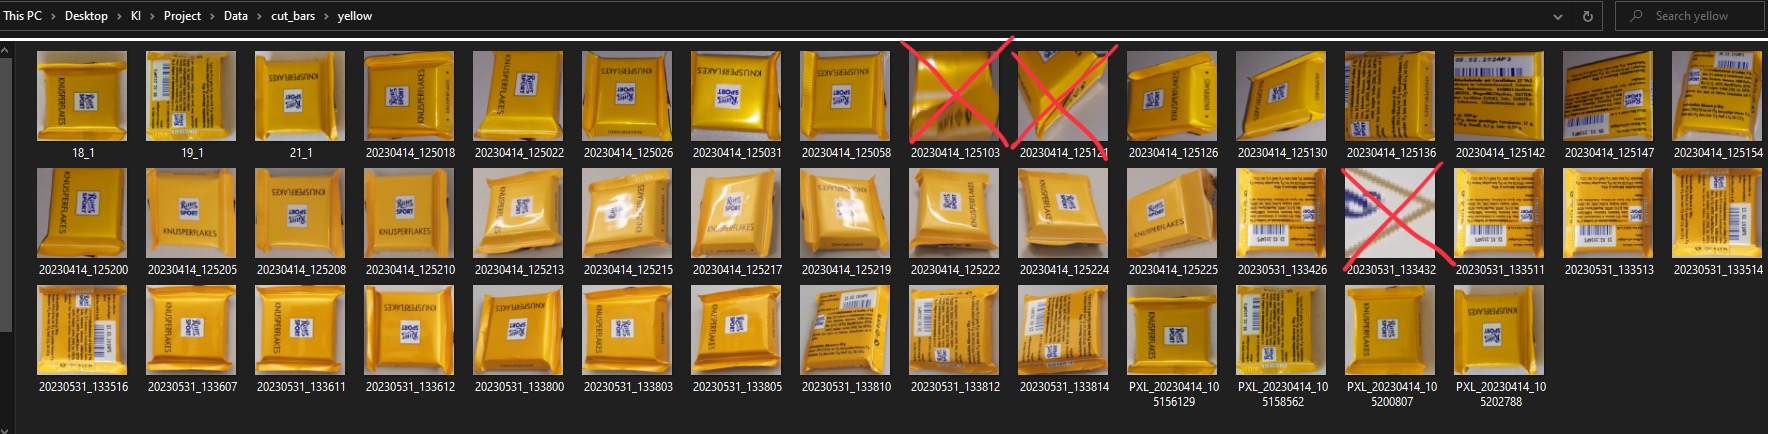


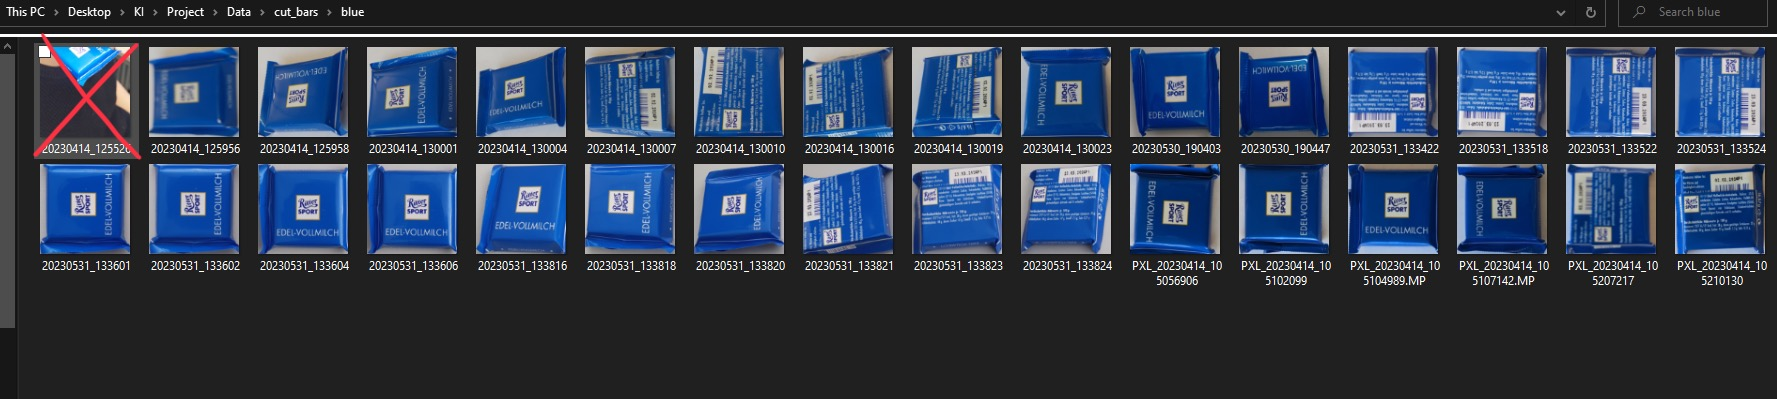

# Feature Extraction and Selection for Classifier Training 

In [49]:
def extract_std_rgb_values(image):
    # Calculate the standard deviation of the Red, Green, and Blue channels
    std_r = np.std(image[:, :, 0])
    std_g = np.std(image[:, :, 1])
    std_b = np.std(image[:, :, 2])
    return [std_r, std_g, std_b]

def extract_color_histogram(image):
    hist = cv2.calcHist([image], [0, 1, 2], None, [4, 4, 4], [0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    reduced_hist = hist[:1]  # Extract the first histogram feature
    return reduced_hist

def extract_color_moments(image):
    # Calculate the skewness of the color distribution
    channels = cv2.split(image)
    moments = []
    for channel in channels:
        moments.append(np.mean(channel) / np.std(channel))
    return moments

def extract_dominant_color(image):
    # Reshape the image to a 2D array where each row represents a pixel's color values
    flattened_img = image.reshape(-1, image.shape[-1])
    
    # Get unique colors and their counts
    colors, count = np.unique(flattened_img, axis=0, return_counts=True)
    
    # Find the index of the most frequent color
    dominant_color_index = count.argmax()
    
    # Return the most dominant color
    return colors[dominant_color_index]

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:12<00:00,  1.81s/it]


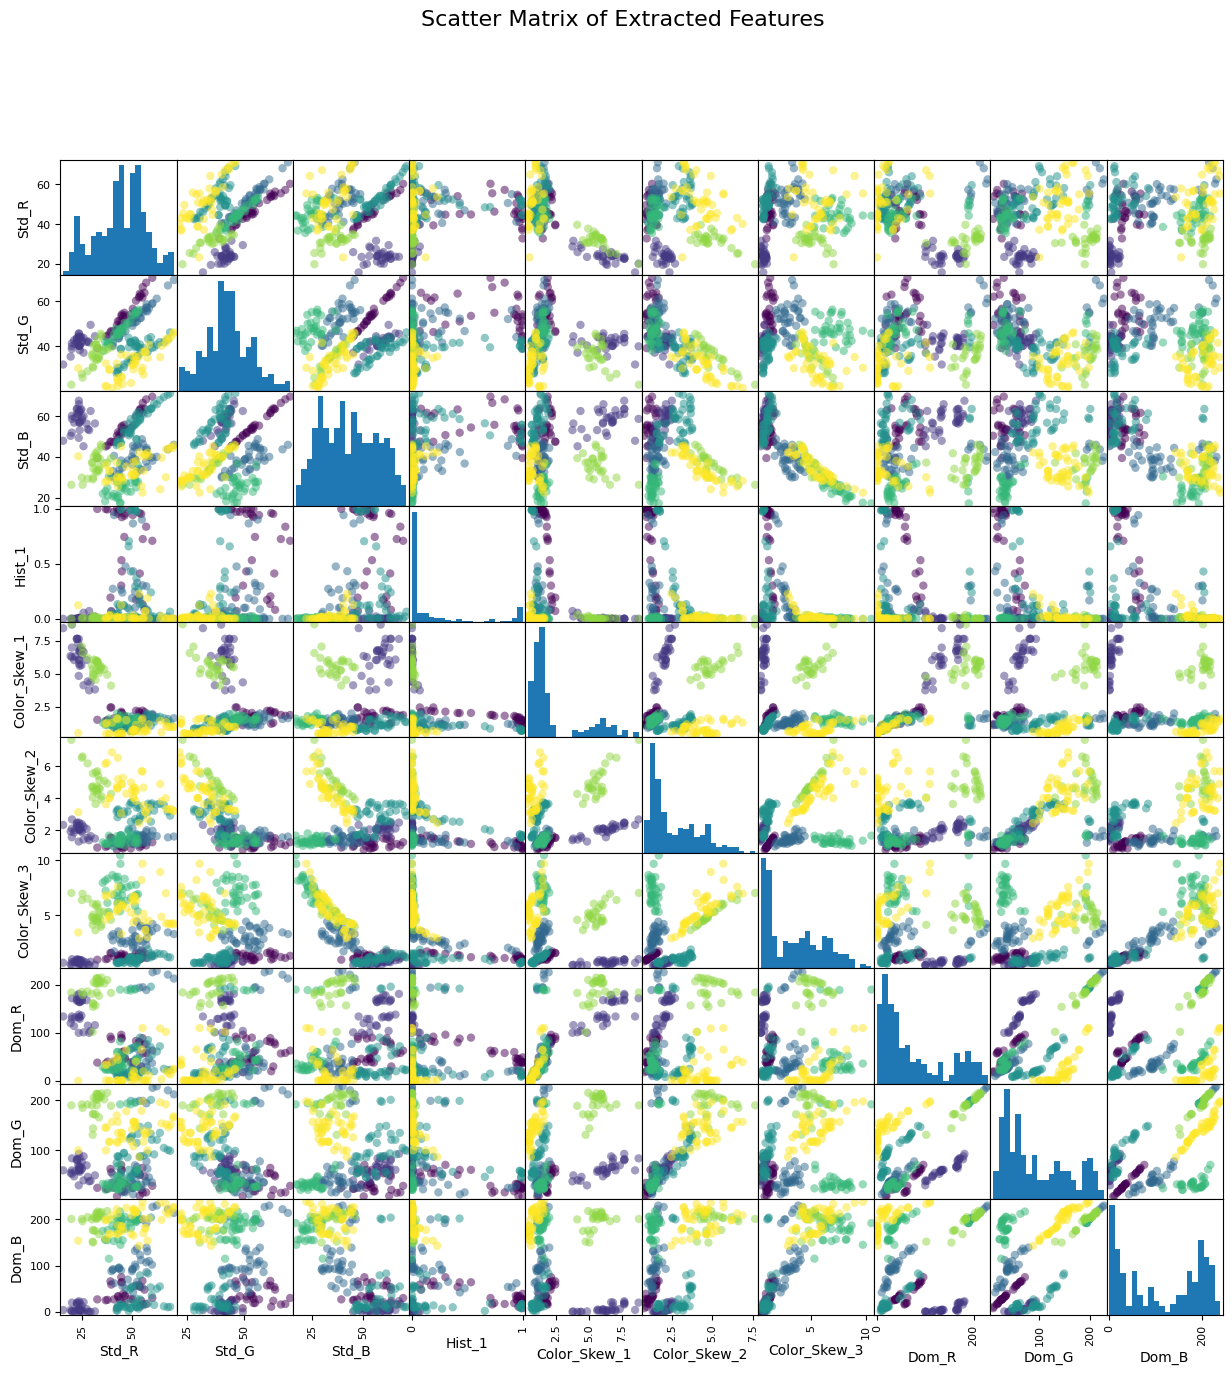

In [155]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from pandas.plotting import scatter_matrix

files = {col.name:os.listdir('%s\%s'%(cut_bars_dir, col.name)) for col in (Colour)}

labels = []
images = []

for colour, files_list in tqdm(files.items()):
    for file_name in files_list:
        imagePath = r'%s\%s\%s'%(cut_bars_dir, colour, file_name)
        img = cv2.imread(imagePath)
    
        # Extract the features from the image
        features = []
        features.extend(extract_std_rgb_values(img))
        features.extend(extract_color_histogram(img))
        features.extend(extract_color_moments(img))
        features.extend(extract_dominant_color(img))

        # Append the features and the label (file name) to the lists
        images.append(features)
        labels.append(Colour[colour].value)

# Create a DataFrame from the extracted features

df = pd.DataFrame(images, columns=['Std_R', 'Std_G', 'Std_B', 
                                   'Hist_1',
                                   'Color_Skew_1', 'Color_Skew_2', 'Color_Skew_3',
                                   'Dom_R', 'Dom_G', 'Dom_B'])

# Generate the scatter matrix
scatter_matrix(df, c=labels, figsize=(15, 15), marker='o', hist_kwds={'bins': 20})

plt.suptitle('Scatter Matrix of Extracted Features', fontsize=16)

# Show the scatter matrix
plt.show()

In [50]:
def dominant_colour(img):
    # Reshape the image to a 2D array where each row represents a pixel's color values
    flattened_img = img.reshape(-1, img.shape[-1])
    
    # Get unique colors and their counts
    colors, count = np.unique(flattened_img, axis=0, return_counts=True)
    
    # Find the index of the most frequent color
    dominant_color_index = count.argmax()
    
    # Return the most dominant color
    return colors[dominant_color_index]


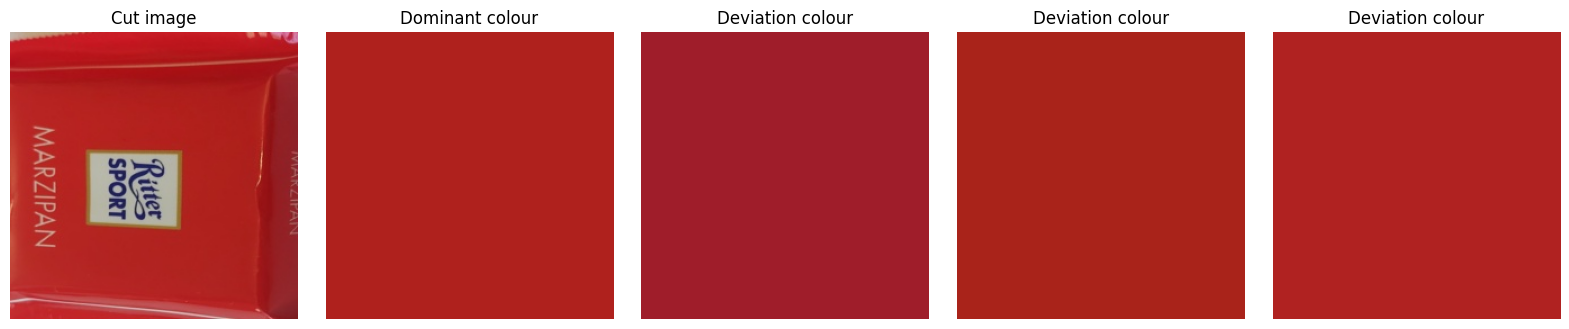

In [51]:
f, axarr = plt.subplots(nrows=1, ncols=5, figsize=(20, 20),
                       gridspec_kw={
                           'width_ratios': [1, 1, 1, 1, 1],
                           'height_ratios': [1],
                       'wspace': 0.1,
                       'hspace': 0.5})


img = cv2.imread(r'C:\Users\mikho\Desktop\KI\CustomDecisionTree + NaiveBayesClassifier\Data\cut_bars\red\20230414_130145.jpg')
img_color = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #otherwise color is inverted

axarr[0].imshow(img_color)
axarr[0].set_title("Cut image")
axarr[0].axis('off')

d_colour = dominant_colour(img_color)
data_3d = np.ndarray(shape=(img_color.shape[0], img_color.shape[1], 3), dtype=int)

data_3d[:][:] = d_colour
axarr[1].imshow(data_3d)
axarr[1].set_title("Dominant colour")
axarr[1].axis('off')

for i in range(3):
    deviation = list(np.random.choice(range(-20, 20), size=3))
    new_color = np.add(d_colour, deviation)
    data_3d[:][:] = new_color
    axarr[i + 2].imshow(data_3d)                  
    axarr[i+ 2].set_title("Deviation colour")
    axarr[i+ 2].axis('off')
    

# Decision tree

In [52]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from tabulate import tabulate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [53]:
class CustomDecisionTree:
    def __init__(self):
        self.tree = None

    def train(self, X_train, y_train, max_depth=None):
        self.tree = self.build_tree(X_train, y_train, max_depth)

    def build_tree(self, X, y, max_depth=None, depth=0):
        if len(np.unique(y)) == 1:
            # If all samples belong to the same class, create a leaf node
            return {'class': y[0]}

        if max_depth is not None and depth >= max_depth:
            # If maximum depth is reached, create a leaf node with the majority class
            majority_class = self.get_majority_class(y)
            if majority_class is None:
                return {'class': None}
            return {'class': majority_class}

        num_features = X.shape[1]
        best_feature, best_threshold = None, None
        best_gini = 1.0  # Initialize the best Gini index

        for feature in range(num_features):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                left_indices = X[:, feature] <= threshold
                right_indices = X[:, feature] > threshold

                left_gini = self.compute_gini(y[left_indices])
                right_gini = self.compute_gini(y[right_indices])

                gini = (len(y[left_indices]) * left_gini + len(y[right_indices]) * right_gini) / len(y)

                if gini < best_gini:
                    best_feature = feature
                    best_threshold = threshold
                    best_gini = gini

        if best_feature is None or best_threshold is None:
            # If no split is found, create a leaf node with the majority class
            return {'class': self.get_majority_class(y)}

        left_indices = X[:, best_feature] <= best_threshold
        right_indices = X[:, best_feature] > best_threshold
        
        

        left_subtree = self.build_tree(X[left_indices], y[left_indices], max_depth, depth + 1)
        right_subtree = self.build_tree(X[right_indices], y[right_indices], max_depth, depth + 1)

        return {'feature': best_feature, 'threshold': best_threshold,
                'left': left_subtree, 'right': right_subtree}

    def compute_gini(self, y):
        classes, counts = np.unique(y, return_counts=True)
        class_probabilities = counts / len(y)
        gini = 1.0 - np.sum(class_probabilities ** 2)
        return gini

    def get_majority_class(self, y):
        default_class_value = 0
        
        if len(y) == 0:
            return default_class_value  # Specify a default class value here or handle it as needed

        classes, counts = np.unique(y, return_counts=True)
        if len(classes) == 0 or len(counts) == 0:
            return default_class_value  # Specify a default class value here or handle it as needed

        majority_index = np.argmax(counts)
        return classes[majority_index]

    def predict(self, X_test):
        predictions = []
        for sample in X_test:
            predictions.append(self.predict_sample(sample))
        return np.array(predictions)

    def predict_sample(self, sample):
        node = self.tree
        while 'class' not in node:
            if sample[node['feature']] <= node['threshold']:
                node = node['left']
            else:
                node = node['right']
        return node['class']

In [54]:
class NaiveBayesClassifier:
    def __init__(self):
        self.classes = None
        self.class_priors = None
        self.feature_probs = None

    def fit(self, X, y):
        self.classes = np.unique(y)
        num_classes = len(self.classes)
        num_features = X.shape[1]

        self.class_priors = np.zeros(num_classes)
        self.feature_probs = np.zeros((num_classes, num_features))

        for i, c in enumerate(self.classes):
            # Subset the training data for the current class
            X_c = X[y == c]

            # Calculate class priors (probability of each class)
            self.class_priors[i] = X_c.shape[0] / X.shape[0]

            # Calculate feature probabilities (conditional probability of each feature given the class)
            self.feature_probs[i] = (X_c.sum(axis=0) + 1) / (np.sum(X_c) + num_features)

    def predict(self, X):
        # Calculate the logarithm of class priors and feature probabilities
        log_priors = np.log(self.class_priors)
        log_feature_probs = np.dot(X, np.log(self.feature_probs.T))

        # Calculate the probabilities of each class for each sample
        probabilities = log_priors + log_feature_probs

        # Predict the class with the highest probability for each sample
        return self.classes[np.argmax(probabilities, axis=1)]

In [55]:
def print_metrics(name, y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    cm = confusion_matrix(y_true, y_pred)

    table_data = [
        ["Accuracy", accuracy],
        ["Precision", precision],
        ["Recall", recall],
        ["F1-score", f1]
    ]

    table_headers = [name + " Metrics", "Score"]

    print(tabulate(table_data, headers=table_headers, tablefmt="grid"))
    print("\nConfusion Matrix:")
    print(cm)

## Feature Extraction from Pictures

In [56]:
%%time

cut_bars_dir = r'%s\cut_bars'%(dir_name)

files = {col.name:os.listdir('%s\%s'%(cut_bars_dir, col.name)) for col in (Colour)}

labels = []
data = []

for colour, files_list in files.items():
    for file_name in files_list:
        imagePath = r'%s\%s\%s'%(cut_bars_dir, colour, file_name)
        img = cv2.imread(imagePath)
        d_colour = dominant_colour(img)
        data.append(d_colour)
        labels.append(Colour[colour].value)
        
print("Extracted from pictures data len: ",len(data))
#print(data)

Extracted from pictures data len:  244
CPU times: total: 10.9 s
Wall time: 10.9 s


## Performance Analysis of CustomDecisionTree and DecisionTreeClassifier based on Augmentation Scale and Max Depths

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:26<00:00, 21.00s/it]


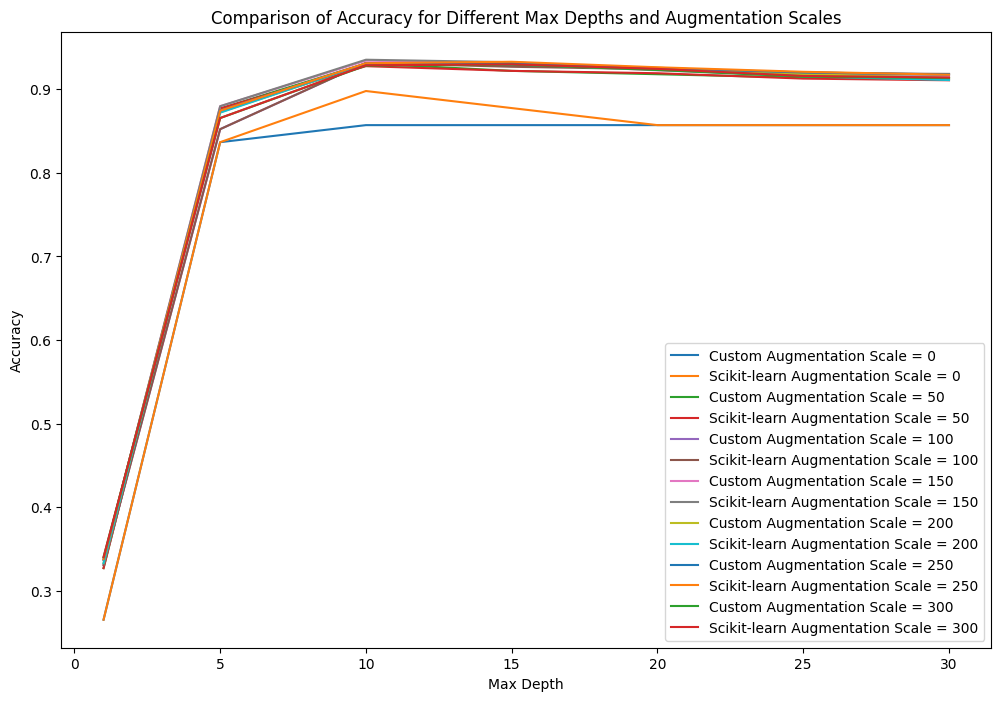

In [16]:
max_depths = [1, 5, 10, 15, 20, 25, 30]
augmentation_scales = [0, 50, 100, 150, 200, 250, 300]
custom_accuracies = np.zeros((len(augmentation_scales), len(max_depths)))
sklearn_accuracies = np.zeros((len(augmentation_scales), len(max_depths)))

for i, scale in enumerate(tqdm(augmentation_scales)):
    new_data = data.copy()
    new_labels = labels.copy()

    for d, l in zip(data, labels):
        for j in range(scale):
            deviation = list(np.random.choice(range(-20, 20), size=3))
            new_colour = np.add(d, deviation)
            feature = np.clip(new_colour, 0, 255)
            new_data.append(feature)
            new_labels.append(l)

    (trainData, testData, trainLabels, testLabels) = train_test_split(np.array(new_data), np.array(new_labels),
                                                                      test_size=0.2, random_state=42)

    for j, depth in enumerate(max_depths):
        # Using custom Decision Tree Classifier
        custom_classifier = CustomDecisionTree()
        custom_classifier.train(trainData, trainLabels, max_depth=depth)
        custom_predictions = custom_classifier.predict(testData)
        custom_accuracy = accuracy_score(testLabels, custom_predictions)
        custom_accuracies[i, j] = custom_accuracy

        # Using scikit-learn's DecisionTreeClassifier
        sklearn_classifier = DecisionTreeClassifier(max_depth=depth)
        sklearn_classifier.fit(trainData, trainLabels)
        sklearn_predictions = sklearn_classifier.predict(testData)
        sklearn_accuracy = accuracy_score(testLabels, sklearn_predictions)
        sklearn_accuracies[i, j] = sklearn_accuracy

# print("Custom Decision Tree Accuracies:")
# for i, scale in enumerate(augmentation_scales):
#     for j, depth in enumerate(max_depths):
#         print(f"Augmentation Scale: {scale}, Max Depth: {depth}, Accuracy: {custom_accuracies[i, j]}")

# print("\nScikit-learn Decision Tree Accuracies:")
# for i, scale in enumerate(augmentation_scales):
#     for j, depth in enumerate(max_depths):
#         print(f"Augmentation Scale: {scale}, Max Depth: {depth}, Accuracy: {sklearn_accuracies[i, j]}")

        
# Plotting the results
plt.figure(figsize=(12, 8))
for i, scale in enumerate(augmentation_scales):
    plt.plot(max_depths, custom_accuracies[i, :], label=f'Custom Augmentation Scale = {scale}')
    plt.plot(max_depths, sklearn_accuracies[i, :], label=f'Scikit-learn Augmentation Scale = {scale}')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Comparison of Accuracy for Different Max Depths and Augmentation Scales')
plt.legend()
plt.show()

### Data Augmentation with Random Color Deviation and Train-Test Split
The code snippet performs data augmentation by applying random color deviation to each sample in the dataset. It iterates over the original data and labels, adding 130 augmented samples with random color deviations. The augmented data is then split into training and testing sets using a test size of 20%. 

In [57]:
%%time

new_data = data.copy()
new_labels = labels.copy()
    
for d, l in zip(data, labels):
    for j in range(150):
        deviation = list(np.random.choice(range(-20, 20), size=3))
        new_colour = np.add(d, deviation)
        feature = np.clip(new_colour, 0, 255)
        new_data.append(feature)
        new_labels.append(l)

(trainData, testData, trainLabels, testLabels) = train_test_split(np.array(new_data), np.array(new_labels),
                                                                  test_size=0.2,random_state=42)


print("Train data length: ",len(trainData))
print("Test data length: ",len(testData))

Train data length:  29475
Test data length:  7369
CPU times: total: 1.08 s
Wall time: 1.05 s


### Comparison of Custom Decision Tree Classifier and Scikit-learn's DecisionTreeClassifier

In [58]:
%%time

# Using custom Decision Tree Classifier
custom_classifier = CustomDecisionTree()
custom_classifier.train(trainData, trainLabels, max_depth=15)
custom_predictions = custom_classifier.predict(testData)

# Using scikit-learn's DecisionTreeClassifier
sklearn_classifier = DecisionTreeClassifier(max_depth=15)
sklearn_classifier.fit(trainData, trainLabels)
sklearn_predictions = sklearn_classifier.predict(testData)

print_metrics("Custom Decision Tree Classifier", testLabels, custom_predictions)
print()
print_metrics("Sklearn DecisionTreeClassifier Accuracy", testLabels, sklearn_predictions)

+-------------------------------------------+----------+
| Custom Decision Tree Classifier Metrics   |    Score |
+===========================================+==========+
| Accuracy                                  | 0.93147  |
+-------------------------------------------+----------+
| Precision                                 | 0.938614 |
+-------------------------------------------+----------+
| Recall                                    | 0.93147  |
+-------------------------------------------+----------+
| F1-score                                  | 0.932696 |
+-------------------------------------------+----------+

Confusion Matrix:
[[ 900    0   15   17    0    0    0]
 [   2  958    0    0    0    0    0]
 [  37    0  882   10   33  137    0]
 [  16    0    2 1146    8   77    0]
 [   0    0   23    0  927   73    0]
 [   0    0   28    3   23  728    0]
 [   0    0    0    0    1    0 1323]]

+---------------------------------------------------+----------+
| Sklearn DecisionTre

In [59]:
custom_classifier = NaiveBayesClassifier()
custom_classifier.fit(trainData, trainLabels)

# Predict using the custom classifier
custom_predictions = custom_classifier.predict(testData)


# Create and train the scikit-learn Naive Bayes classifier
sklearn_classifier_MultinomialNB = MultinomialNB()
sklearn_classifier_MultinomialNB.fit(trainData, trainLabels)

# Predict using the scikit-learn classifier
sklearn_predictions_MultinomialNB = sklearn_classifier_MultinomialNB.predict(testData)


# Create and train the Naive Bayes classifier using scikit-learn
sklearn_classifier_GaussianNB = GaussianNB()
sklearn_classifier_GaussianNB.fit(trainData, trainLabels)

# Make predictions using scikit-learn
sklearn_predictions_GaussianNB = sklearn_classifier_GaussianNB.predict(testData)


print_metrics("Custom Naive Bayes", testLabels, custom_predictions)
print()
print_metrics("Scikit-learn MultinomialNB", testLabels, sklearn_predictions_MultinomialNB)
print()
print_metrics("Scikit-learn GaussianNB", testLabels, sklearn_predictions_GaussianNB)


+------------------------------+----------+
| Custom Naive Bayes Metrics   |    Score |
+==============================+==========+
| Accuracy                     | 0.797394 |
+------------------------------+----------+
| Precision                    | 0.820931 |
+------------------------------+----------+
| Recall                       | 0.797394 |
+------------------------------+----------+
| F1-score                     | 0.787945 |
+------------------------------+----------+

Confusion Matrix:
[[ 573   97   51   31   18  161    1]
 [   4  956    0    0    0    0    0]
 [   0    0  385    0  354  238  122]
 [   0    6    0 1098    0  102   43]
 [   0    0    1    0  899  110   13]
 [   1    0   13    0    0  768    0]
 [   0    0  127    0    0    0 1197]]

+--------------------------------------+----------+
| Scikit-learn MultinomialNB Metrics   |    Score |
+======================================+==========+
| Accuracy                             | 0.797394 |
+--------------------

# Object Detection

To localize the object, we have to select sub-regions (patches) of the image and then apply the object classification algorithm to these image patches.

(-0.5, 4623.5, 2603.5, -0.5)

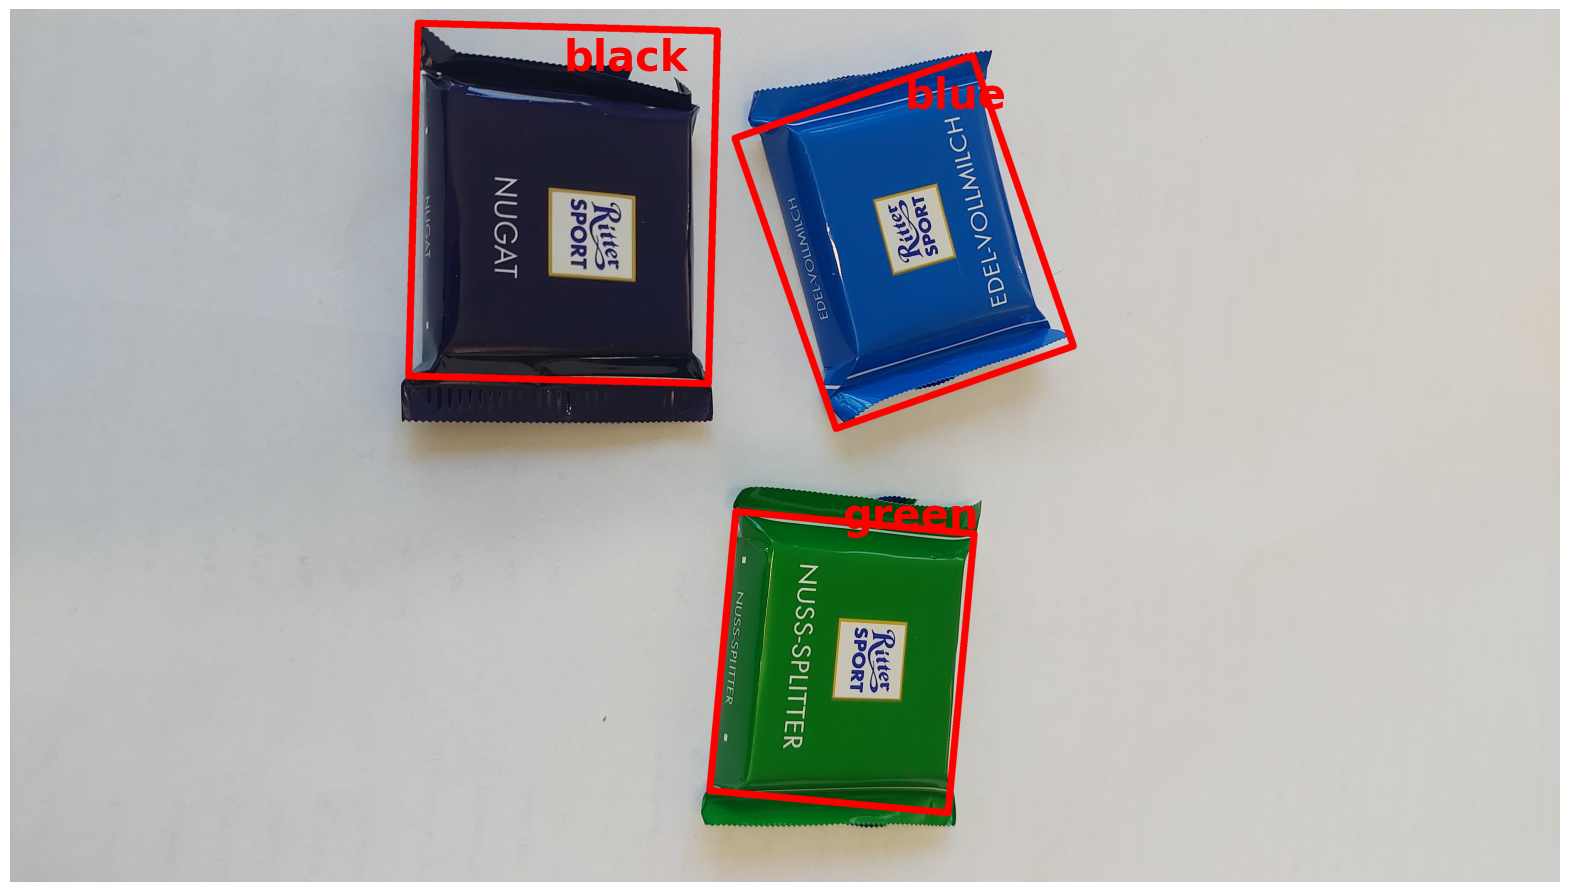

In [60]:
f, axarr = plt.subplots(nrows=1, ncols=1, figsize=(20, 20))


img = cv2.imread(r'C:\Users\mikho\Desktop\KI\VdKI_Projekt SS2023\Bilder_Rittersport_SS2023\20230414_130356\20230414_130506.jpg')
colour_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

boxes, rects = get_bounding_rect_filters(img, multiple=True)

dominant_colours = []
for box, rect in zip(boxes, rects):
    croped_img = crop_img(img, box, rect)
    d_colour = dominant_colour(croped_img)
    dominant_colours.append(d_colour)
    
custom_predictions = custom_classifier.predict(dominant_colours)
sklearn_predictions = sklearn_classifier.predict(dominant_colours)

for ind, col in enumerate(custom_predictions):
    colour_img = cv2.drawContours(colour_img,[boxes[ind]],0,(255,0,0),20)
    axarr.text(rects[ind][0][0],rects[ind][0][1]-500, Colour(col).name, verticalalignment='top',color='red',fontsize=30,weight='bold')

axarr.imshow(colour_img)
axarr.axis('off')

    

# Tested images

4it [00:17,  4.36s/it]


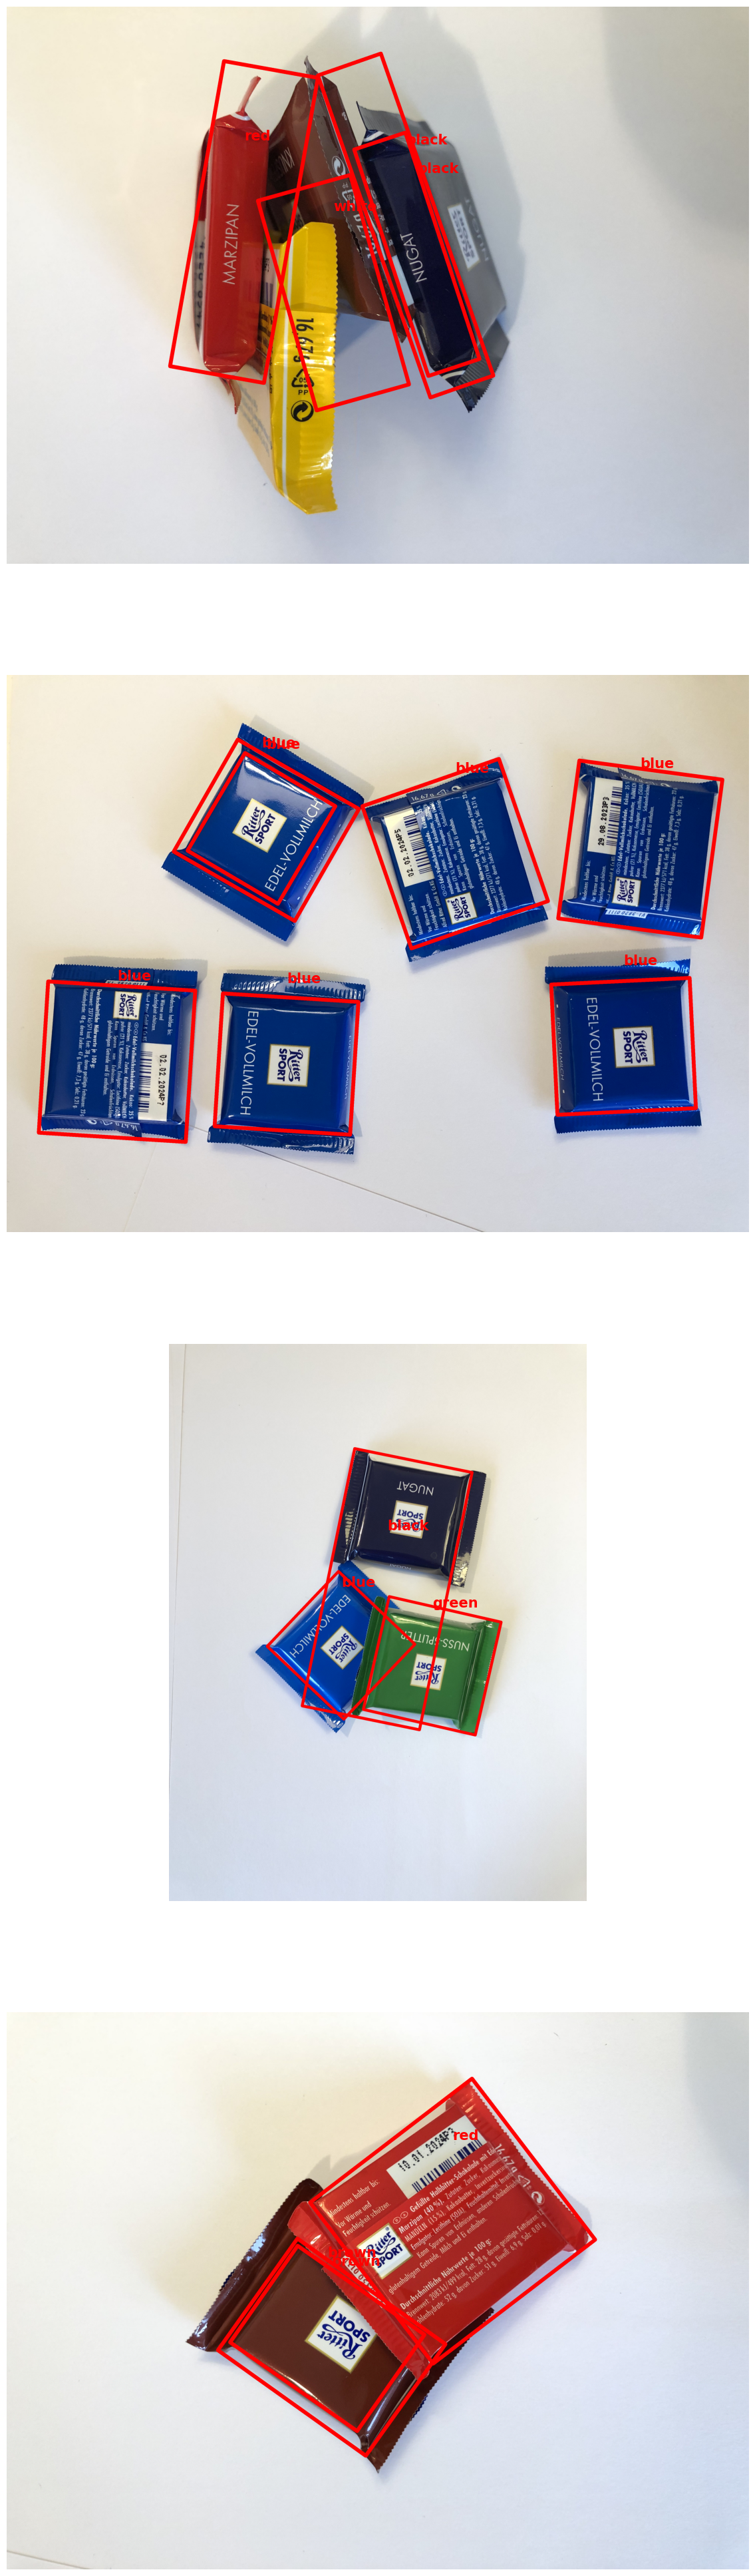

In [71]:
f, axarr = plt.subplots(nrows=4, ncols=1, figsize=(50, 50))


img_names = [
            r'C:\Users\mikho\Desktop\KI\CustomDecisionTree + NaiveBayesClassifier\Bilder\IMG_1836.jpg', 
            r'C:\Users\mikho\Desktop\KI\CustomDecisionTree + NaiveBayesClassifier\Bilder\IMG_1832.jpg', 
            r'C:\Users\mikho\Desktop\KI\CustomDecisionTree + NaiveBayesClassifier\Bilder\IMG_1838.jpg', 
            r'C:\Users\mikho\Desktop\KI\CustomDecisionTree + NaiveBayesClassifier\Bilder\IMG_1827.jpg', ]


for i, name in tqdm(enumerate(img_names)):

    img = cv2.imread(name)
    colour_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    boxes, rects = get_bounding_rect_filters(img, multiple=True, cmp_area = 0.3)

    dominant_colours = []
    for box, rect in zip(boxes, rects):
        croped_img = crop_img(img, box, rect)
        d_colour = dominant_colour(croped_img)
        dominant_colours.append(d_colour)

    custom_predictions = custom_classifier.predict(dominant_colours)
#    sklearn_predictions = sklearn_classifier.predict(dominant_colours)

    for ind, col in enumerate(custom_predictions):
        colour_img = cv2.drawContours(colour_img,[boxes[ind]],0,(255,0,0),20)
        axarr[i-1].text(rects[ind][0][0],rects[ind][0][1]-500, Colour(col).name, verticalalignment='top',color='red',fontsize=15,weight='bold')

    axarr[i-1].imshow(colour_img)
    axarr[i-1].axis('off')
